In [1]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.metrics import root_mean_squared_error
from sklearn.manifold import TSNE
from umap import UMAP
import torch
from torch import nn
import optuna
import importlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(0)

cuda


In [2]:
def reload_utils():
    """Reload all utils modules"""
    import utils.data_utils
    import utils.model_utils
    import utils.train_test_utils
    import utils.plot_utils
    
    importlib.reload(utils.data_utils)
    importlib.reload(utils.model_utils)
    importlib.reload(utils.train_test_utils)
    importlib.reload(utils.plot_utils)

reload_utils()

# Import custom modules
from utils.data_utils import (
    construct_loader,
    get_mol_infos,
)
from utils.model_utils import GNN
from utils.train_test_utils import (
    Standardizer,
    train_epoch,
    train_epoch_without_SSL,
    pred,
    pred_with_TTA,
    embeddings_with_TTA,
)
from utils.plot_utils import (
    solubility_histogram,
    atom_count_histogram,
    functional_group_histogram,
    solubility_histogram_shift,
    solubility_embeddings,
    sets_embeddings,
    centroid_embeddings,
    loss_plot,
)

In [3]:
batch_size = 1024
epochs = 30

hyperparam_opt = True # Optional optimization of hyperparameters

# If wanted, we can load an already trained model
save_model = True  # Set to False if you don't want to save
load_trained_model = False  # Set to True to skip training and load existing model
save_plots = True

assert not (load_trained_model and hyperparam_opt), "Cannot load a model and optimize hyperparameters at the same time."
assert not (load_trained_model and save_model), "Cannot load a model and save it at the same time."

# Data

### Loading the Data

In [4]:
data_df = pd.read_csv("data/AqSolDBc.csv")
# Drop single atoms
idx_single = [
    i
    for i, s in enumerate(data_df["SmilesCurated"])
    if Chem.MolFromSmiles(s).GetNumAtoms() == 1 or "." in s
]

data_df = data_df.drop(idx_single)
if len(idx_single) > 0:
    print(f"Removing {idx_single} due to single atoms")

test_df = pd.read_csv("data/OChemUnseen.csv")
# Drop some Nonetypes
# Got an error for a SMILES which was None
idx_nonetype = [
    i for i, s in enumerate(test_df["SMILES"]) if Chem.MolFromSmiles(s) is None
]

test_df = test_df.drop(idx_nonetype)
if len(idx_nonetype) > 0:
    print(f"Removing {idx_nonetype} due to Nonetypes")

# Drop single atoms
idx_single = [
    i
    for i, s in enumerate(test_df["SMILES"])
    if Chem.MolFromSmiles(s).GetNumAtoms() == 1 or "." in s
]

test_df = test_df.drop(idx_single)
if len(idx_single) > 0:
    print(f"Removing {idx_single} due to single atoms")

# Get additional information on the molecules, such as number of atoms, functional groups
data_df_updated = get_mol_infos(data_df, "SmilesCurated")
test_df_updated = get_mol_infos(test_df, "SMILES")

Removing [1263, 1444, 3605, 3702] due to single atoms


[21:10:33] Explicit valence for atom # 1 P, 6, is greater than permitted


Removing [667] due to Nonetypes
Removing [471, 503, 589, 591, 592, 593, 594, 610, 613, 641, 643, 647, 649, 652, 653, 654, 656, 658, 676, 681, 693, 744, 759, 763, 769, 773, 777, 807, 809, 811, 813, 869, 902, 969, 998] due to single atoms


### Analyzing the Data

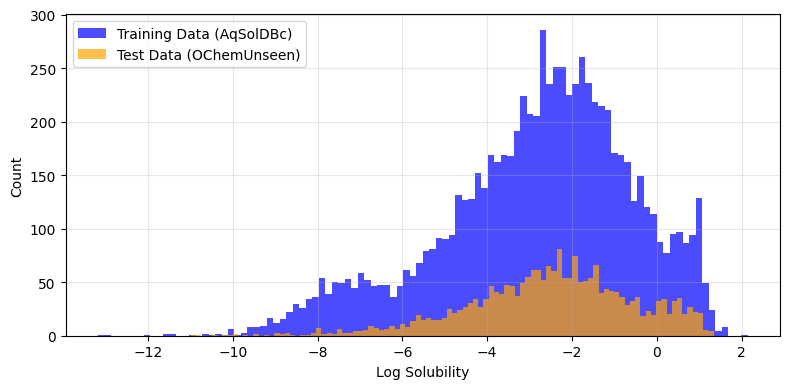

In [5]:
solubility_histogram(data_df_updated, test_df_updated, save_plots=save_plots)


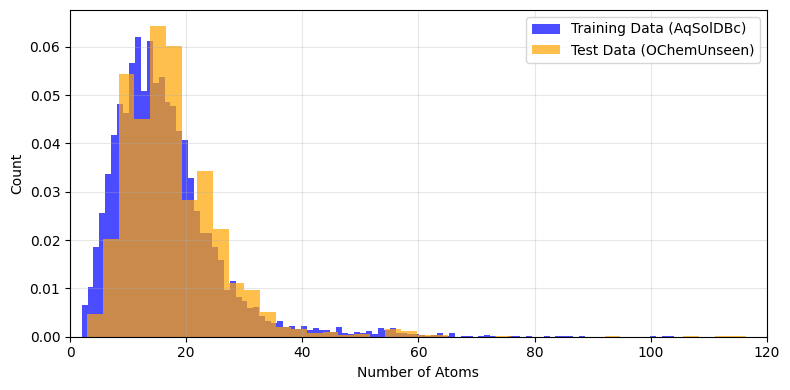

In [6]:
atom_count_histogram(data_df_updated, test_df_updated, save_plots=save_plots)

d:\Philipp\Studium\Molecular-Test-Time-Adaptation\utils\plot_utils.py:255: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


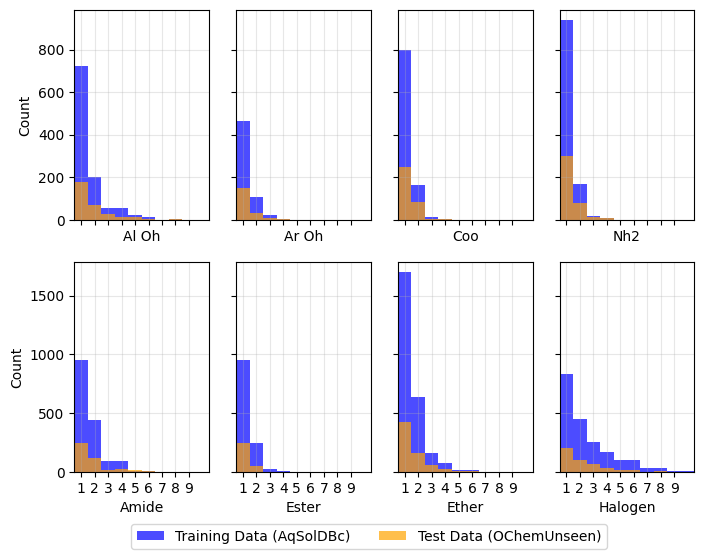

In [7]:
functional_group_histogram(data_df_updated, test_df_updated, save_plots=save_plots)

### Creating a distribution shift

In [8]:
print(f"Dataset size before filtering: {len(data_df_updated)}, {len(test_df_updated)}")

data_df_filtered = data_df_updated[
    (data_df_updated["num_atoms"] < 20) & (data_df_updated["fr_NH2"] == 0) 
]
test_df_filtered_20 = test_df_updated[
    (test_df_updated["num_atoms"] >= 20) & (test_df_updated["fr_NH2"] == 0)
]
test_df_filtered_nh = test_df_updated[
    (test_df_updated["num_atoms"] >= 20) & (test_df_updated["fr_NH2"] > 0)
]

train_df = data_df_filtered[data_df_filtered["num_atoms"] > 5]
val_df = data_df_filtered[data_df_filtered["num_atoms"] <= 5]

# We are increasing the already existing distribution shift between the train and test sets by filtering for atom counts and functional groups
# The train and validation sets will contain molecules with less than 20 atoms and no NH2 functional groups
# Specifically, the train set will also only contain molecules with more than 5 atoms
# The validation set will also only contain molecules with 5 atoms or less

# The first test set will contain molecules with more than 20 atoms
# The second test set will contain molecules with more than 20 atoms and NH2 functional groups

print(
    f"Dataset size after filtering: {len(train_df)}, {len(val_df)}, {len(test_df_filtered_20)}, {len(test_df_filtered_nh)}"
)

Dataset size before filtering: 8047, 2251
Dataset size after filtering: 4755, 259, 553, 153


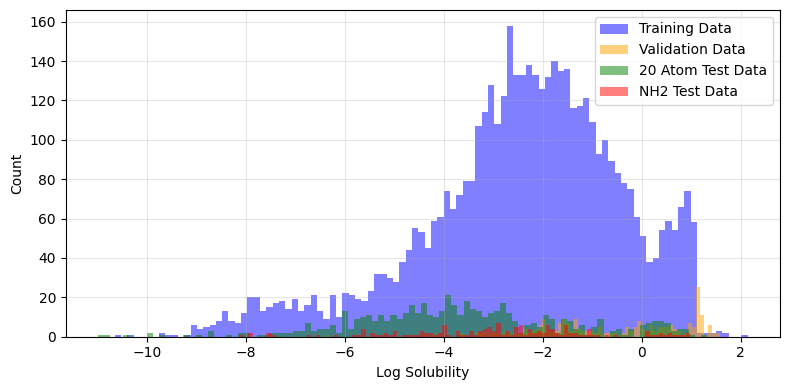

In [9]:
solubility_histogram_shift(train_df, val_df, test_df_filtered_20, test_df_filtered_nh, save_plots=save_plots)

# Training

In [10]:
train_loader = construct_loader(
    train_df, "SmilesCurated", "ExperimentalLogS", shuffle=True, batch_size=batch_size
)
val_loader = construct_loader(
    val_df, "SmilesCurated", "ExperimentalLogS", shuffle=False, batch_size=1
)

test_loader_20 = construct_loader(
    test_df_filtered_20, "SMILES", "LogS", shuffle=False, batch_size=1
)
test_loader_nh = construct_loader(
    test_df_filtered_nh, "SMILES", "LogS", shuffle=False, batch_size=1
)
print(
    f"Train size: {len(train_loader.dataset)}, Val size: {len(val_loader.dataset)}, Test size 20 Atom: {len(test_loader_20.dataset)}, Test size NH2: {len(test_loader_nh.dataset)}"
)

# Standardizer for the solubility labels
mean = np.mean(train_loader.dataset.labels)
std = np.std(train_loader.dataset.labels)
stdzer = Standardizer(mean, std)

Train size: 4755, Val size: 259, Test size 20 Atom: 553, Test size NH2: 153


### Train Hyperparameter optimization

In [ ]:
# Optional hyperparameter optimization on the validation set

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True) 
    # Size of the encoder-decoder bottleneck
    hidden_size = trial.suggest_categorical("hidden_size", [32])  
    depth = trial.suggest_categorical("depth", [2, 3, 4])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2])
    weight_decay = trial.suggest_float("weight_decay", 5e-5, 5e-4, log=True)
    use_layer_norm = trial.suggest_categorical("use_layer_norm", [False])
    use_residual = trial.suggest_categorical("use_residual", [False])

    model = GNN(
        train_loader.dataset.num_node_features,
        train_loader.dataset.num_edge_features,
        hidden_size=hidden_size,
        depth=depth,
        dropout=dropout,
        use_layer_norm=use_layer_norm,
        use_residual=use_residual,
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    loss = nn.MSELoss(reduction="mean")

    # By default, we train for a third of the epochs used in the main training to get a rough estimate
    for epoch in range(epochs // 3):
        train_epoch(model, train_loader, optimizer, loss, stdzer)

        preds = pred(model, val_loader, mode='predict', stdzer=stdzer)
        rmse_pred = root_mean_squared_error(preds, val_loader.dataset.labels)

        trial.report(rmse_pred, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return rmse_pred

In [ ]:
if hyperparam_opt:
    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=8, n_warmup_steps=epochs//6, interval_steps=2
        ),
        study_name="hyperparam_opt",
    )

    study.optimize(objective, n_trials=40, n_jobs=2)

    print(f"Best learning rate: {study.best_params['learning_rate']:.4f}")
    print(f"Best hidden size: {study.best_params['hidden_size']:.4f}")
    print(f"Best depth: {study.best_params['depth']:.4f}")
    print(f"Best dropout: {study.best_params['dropout']:.4f}")
    print(f"Best weight decay: {study.best_params['weight_decay']:.8f}")
    print(f"Best layer norm choice: {study.best_params['use_layer_norm']}")
    print(f"Best residual choice: {study.best_params['use_residual']}")

    study_results = study.trials_dataframe()
    study_results.to_csv("data/hyperparam_opt.csv", index=False)
    print("Study results saved to hyperparam_opt.csv")

    learning_rate = study.best_params["learning_rate"]
    hidden_size = study.best_params["hidden_size"]
    depth = study.best_params["depth"]
    dropout = study.best_params["dropout"]
    weight_decay = study.best_params["weight_decay"]
    use_layer_norm = study.best_params["use_layer_norm"]
    use_residual = study.best_params["use_residual"]

    torch.cuda.empty_cache()

# Standard hyperparameters are the result of a previous hyperparameter optimization
else:
    learning_rate = 0.0097
    hidden_size = 32
    depth = 3
    dropout = 0.1
    weight_decay = 0.000074
    use_layer_norm = False
    use_residual = False

[I 2025-06-04 21:10:47,820] A new study created in memory with name: hyperparam_opt
[I 2025-06-04 21:14:37,108] Trial 1 finished with value: 1.9357181421111045 and parameters: {'learning_rate': 0.00022262114254708025, 'hidden_size': 16, 'depth': 2, 'dropout': 0.2, 'weight_decay': 2.180615929536528e-05, 'use_layer_norm': True, 'use_residual': True}. Best is trial 1 with value: 1.9357181421111045.
[I 2025-06-04 21:14:42,254] Trial 0 finished with value: 2.379504013775463 and parameters: {'learning_rate': 0.007167030646240476, 'hidden_size': 32, 'depth': 3, 'dropout': 0.2, 'weight_decay': 1.0203932088876299e-05, 'use_layer_norm': True, 'use_residual': True}. Best is trial 1 with value: 1.9357181421111045.
[I 2025-06-04 21:18:17,768] Trial 2 finished with value: 2.221442157922171 and parameters: {'learning_rate': 0.0017110030244958468, 'hidden_size': 16, 'depth': 2, 'dropout': 0.1, 'weight_decay': 8.325317442635298e-06, 'use_layer_norm': False, 'use_residual': False}. Best is trial 1 with 

Best learning rate: 0.0097
Best hidden size: 32.0000
Best depth: 3.0000
Best dropout: 0.1000
Best weight decay: 0.00007378
Best layer norm choice: False
Best residual choice: False
Study results saved to hyperparam_opt.csv


### Training on both Tasks

In [13]:
model = GNN(
    train_loader.dataset.num_node_features,
    train_loader.dataset.num_edge_features,
    hidden_size=hidden_size,
    depth=depth,
    dropout=dropout,
    use_layer_norm=use_layer_norm,
    use_residual=use_residual,
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

loss = nn.MSELoss(reduction="mean")
print("\n", model, "\n")


 GNN(
  (encoder): GNNEncoder(
    (edge_init): Linear(in_features=51, out_features=32, bias=True)
    (convs): ModuleList(
      (0-2): 3 x DMPNNConv()
    )
    (edge_to_node): Linear(in_features=76, out_features=32, bias=True)
  )
  (head): GNNHead(
    (ffn1): Linear(in_features=32, out_features=32, bias=True)
    (ffn2): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): GNNDecoder(
    (node_lin): Linear(in_features=32, out_features=44, bias=True)
    (edge_lin): Linear(in_features=32, out_features=7, bias=True)
  )
) 



In [14]:
# If wanted, we can load an already trained model

# Path for the best model
model_path = os.path.join("trained_models", "model.pt")
if load_trained_model and os.path.exists(model_path):
    # Load pretrained model
    print(f"Loading model from {model_path}")
    model.load_state_dict(torch.load(model_path))
    best_model = deepcopy(model).to(device)
    # Skip training
    epochs = 0

In [15]:
# Training the model on both tasks simultaneously
if not load_trained_model:
    best_model = deepcopy(model).to(device)
    best_combined_val_loss = 1e5

    combined_train_loss_list = []
    denoise_train_loss_list = []
    pred_train_loss_list = []

    combined_val_loss_list = []
    denoise_val_loss_list = []
    pred_val_loss_list = []

    if epochs == 0:
        print("Skipping training, previously trained model was loaded.")

    for epoch in range(0, epochs):
        combined_train_loss, denoise_train_loss, pred_train_loss = train_epoch(
            model, train_loader, optimizer, loss, stdzer=stdzer
        )

        denoised = pred(model, val_loader, mode="denoise", stdzer=stdzer)
        node_feature_targets = [
            feature
            for batch in val_loader
            for feature in batch.x.cpu().flatten().tolist()
        ]
        
        edge_feature_targets = [
            feature
            for batch in val_loader
            for feature in batch.edge_attr.cpu().flatten().tolist()
        ]

        denoise_val_loss = root_mean_squared_error(
            denoised, node_feature_targets + edge_feature_targets
        )

        preds = pred(model, val_loader, mode='predict', stdzer=stdzer)
        pred_val_loss = root_mean_squared_error(preds, val_loader.dataset.labels)
        combined_val_loss = denoise_val_loss + pred_val_loss

        print(
            f"Epoch {epoch}  Train Denoise Loss: {denoise_train_loss:.3f}  Train Pred Loss: {pred_train_loss:.3f}  Val Denoise Loss: {denoise_val_loss:.3f}  Val Pred Loss: {pred_val_loss:.3f}"
        )

        combined_train_loss_list.append(combined_train_loss)
        denoise_train_loss_list.append(denoise_train_loss)
        pred_train_loss_list.append(pred_train_loss)
        denoise_val_loss_list.append(denoise_val_loss)
        pred_val_loss_list.append(pred_val_loss)
        combined_val_loss_list.append(combined_val_loss)


        if combined_val_loss < best_combined_val_loss:
            best_model = deepcopy(model).to(device)
            best_combined_val_loss = combined_val_loss

            # Save the best model
            if save_model:
                print(f"Saving best model based on combined Val Loss...")
                torch.save(
                    best_model.state_dict(), os.path.join("trained_models", f"model.pt")
                )

Epoch 0  Train Denoise Loss: 0.051  Train Pred Loss: 0.032  Val Denoise Loss: 0.379  Val Pred Loss: 2.212
Saving best model based on combined Val Loss...
Epoch 1  Train Denoise Loss: 0.021  Train Pred Loss: 0.028  Val Denoise Loss: 0.369  Val Pred Loss: 2.023
Saving best model based on combined Val Loss...
Epoch 2  Train Denoise Loss: 0.020  Train Pred Loss: 0.025  Val Denoise Loss: 0.364  Val Pred Loss: 1.880
Saving best model based on combined Val Loss...
Epoch 3  Train Denoise Loss: 0.019  Train Pred Loss: 0.023  Val Denoise Loss: 0.360  Val Pred Loss: 1.813
Saving best model based on combined Val Loss...
Epoch 4  Train Denoise Loss: 0.018  Train Pred Loss: 0.022  Val Denoise Loss: 0.359  Val Pred Loss: 1.604
Saving best model based on combined Val Loss...
Epoch 5  Train Denoise Loss: 0.017  Train Pred Loss: 0.021  Val Denoise Loss: 0.357  Val Pred Loss: 1.479
Saving best model based on combined Val Loss...
Epoch 6  Train Denoise Loss: 0.017  Train Pred Loss: 0.021  Val Denoise Loss

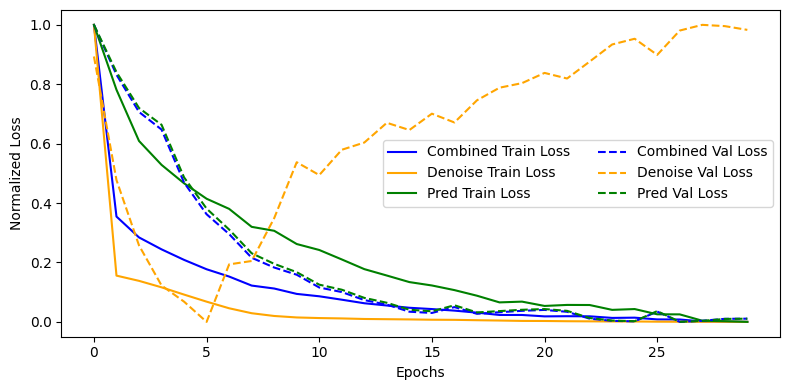

In [16]:
# Only plot if actual training was done
if epochs != 0:
    loss_plot(
        combined_train_loss_list,
        denoise_train_loss_list,
        pred_train_loss_list,
        combined_val_loss_list,
        denoise_val_loss_list,
        pred_val_loss_list,
        save_plots=save_plots,
    )

### TTA Step Size optimization

In [17]:
def objective(trial):
    learning_rate_TTA = trial.suggest_float("learning_rate_TTA", 1e-7, 1e-3, log=True) 
    n_steps_TTA = trial.suggest_int("n_steps_TTA", 1, 10)

    preds = pred_with_TTA(best_model, val_loader, lr=learning_rate_TTA, n_steps=n_steps_TTA, stdzer=stdzer)
    rmse_pred = root_mean_squared_error(preds, val_loader.dataset.labels)

    return rmse_pred

In [ ]:
if hyperparam_opt:
    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.NSGAIISampler(seed=0),
        study_name="hyperparam_opt_TTA",
    )
    
    study.optimize(objective, n_trials=40, n_jobs=4)

    print(f"Best learning rate for TTA: {study.best_params['learning_rate_TTA']:.4f}")
    print(f"Best number of steps for TTA: {study.best_params['n_steps_TTA']}")

    study_results = study.trials_dataframe()
    study_results.to_csv("data/hyperparam_opt_TTA.csv", index=False)
    print("Study results saved to hyperparam_opt_TTA.csv")

    learning_rate_TTA = study.best_params["learning_rate_TTA"]
    n_steps_TTA = study.best_params["n_steps_TTA"]

    torch.cuda.empty_cache()

# Standard hyperparameters are the result of a previous hyperparameter optimization
else:
    learning_rate_TTA = 0.0001
    n_steps_TTA = 3

[I 2025-06-04 22:30:20,874] A new study created in memory with name: hyperparam_opt_TTA
[I 2025-06-04 22:31:17,582] Trial 2 finished with value: 1.0276201964882956 and parameters: {'learning_rate_TTA': 5.425176334369819e-05, 'n_steps_TTA': 7}. Best is trial 2 with value: 1.0276201964882956.
[I 2025-06-04 22:31:18,238] Trial 1 finished with value: 1.0276202723205674 and parameters: {'learning_rate_TTA': 0.00011864642214617487, 'n_steps_TTA': 5}. Best is trial 2 with value: 1.0276201964882956.
[I 2025-06-04 22:31:31,045] Trial 0 finished with value: 1.0276200544370275 and parameters: {'learning_rate_TTA': 4.07776315328057e-06, 'n_steps_TTA': 4}. Best is trial 0 with value: 1.0276200544370275.
[I 2025-06-04 22:31:35,338] Trial 3 finished with value: 1.0276200451910449 and parameters: {'learning_rate_TTA': 1.401075673732954e-07, 'n_steps_TTA': 10}. Best is trial 3 with value: 1.0276200451910449.


### Training without SSL for reference

In [ ]:
model_non_SSL = GNN(
    train_loader.dataset.num_node_features,
    train_loader.dataset.num_edge_features,
    hidden_size=hidden_size,
    depth=depth,
    dropout=dropout,
    use_layer_norm=use_layer_norm,
    use_residual=use_residual,
).to(device)

optimizer_non_SSL = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

loss_non_SSL = nn.MSELoss(reduction="mean")
print("\n", model, "\n")

In [ ]:
# If wanted, we can load an already trained model

# Path for the best model
model_path = os.path.join("trained_models", "model_non_SSL.pt")
if load_trained_model and os.path.exists(model_path):
    # Load pretrained model
    print(f"Loading model from {model_path}")
    model_non_SSL.load_state_dict(torch.load(model_path))
    best_model_non_SSL = deepcopy(model_non_SSL).to(device)
    # Skip training
    epochs = 0

In [ ]:
best_model_non_SSL = deepcopy(model_non_SSL).to(device)
best_val_loss = 1e5

train_loss_list = []
val_loss_list = []

if epochs == 0:
    print("Skipping training, previously trained model was loaded.")

for epoch in range(0, epochs):
    train_loss = train_epoch_without_SSL(
        model_non_SSL,
        train_loader,
        optimizer_non_SSL,
        loss_non_SSL,
        stdzer=stdzer,
    )

    preds = pred(model_non_SSL, val_loader, mode="predict", stdzer=stdzer)
    val_loss = root_mean_squared_error(preds, val_loader.dataset.labels)

    print(f"Epoch {epoch}  Train Loss: {train_loss:.2f}  Val Loss: {val_loss:.2f}")

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if val_loss < best_val_loss:
        best_model_non_SSL = deepcopy(model_non_SSL).to(device)
        best_val_loss = val_loss

        # Save the best model
        if save_model:
            print(f"Saving best model based on Val Loss...")
            torch.save(
                best_model_non_SSL.state_dict(),
                os.path.join("trained_models", f"model_non_SSL.pt"),
            )

# Prediction

In [ ]:
# Prediction with non-SSL model
val_preds_non_SSL = pred(best_model_non_SSL, val_loader, mode="predict", stdzer=stdzer)
test_preds_non_SSL_20 = pred(
    best_model_non_SSL, test_loader_20, mode="predict", stdzer=stdzer
)
test_preds_non_SSL_nh = pred(
    best_model_non_SSL, test_loader_nh, mode="predict", stdzer=stdzer
)

print("Reference results for model trained without any SSL:")
print(
    f"Val Set RMSE: {root_mean_squared_error(val_preds_non_SSL, val_loader.dataset.labels):.4f}"
)
print(
    f"20 Atom Test Set RMSE: {root_mean_squared_error(test_preds_non_SSL_20, test_loader_20.dataset.labels):.4f}"
)
print(
    f"NH2 Test Set RMSE: {root_mean_squared_error(test_preds_non_SSL_nh, test_loader_nh.dataset.labels):.4f}"
)

In [ ]:
# Prediction with SLL model without TTA
val_preds = pred(best_model, val_loader, mode="predict", stdzer=stdzer)
test_preds_20 = pred(best_model, test_loader_20, mode="predict", stdzer=stdzer)
test_preds_nh = pred(best_model, test_loader_nh, mode="predict", stdzer=stdzer)

print("Results without TTA:")
print(
    f"Val Set RMSE: {root_mean_squared_error(val_preds, val_loader.dataset.labels):.4f}"
)
print(
    f"20 Atom Test Set RMSE: {root_mean_squared_error(test_preds_20, test_loader_20.dataset.labels):.4f}"
)
print(
    f"NH2 Test Set RMSE: {root_mean_squared_error(test_preds_nh, test_loader_nh.dataset.labels):.4f}"
)

In [ ]:
# Prediction with SLL model with TTA
# Takes about three times as long as prediction without TTA
val_preds_TTA = pred_with_TTA(
    best_model, val_loader, lr=learning_rate_TTA, stdzer=stdzer
)
test_preds_TTA_20 = pred_with_TTA(
    best_model, test_loader_20, lr=learning_rate_TTA, n_steps=n_steps_TTA, stdzer=stdzer
)
test_preds_TTA_nh = pred_with_TTA(
    best_model, test_loader_nh, lr=learning_rate_TTA, n_steps=n_steps_TTA, stdzer=stdzer
)

print("Results on with TTA:")
print(
    f"Val Set RMSE: {root_mean_squared_error(val_preds_TTA, val_loader.dataset.labels):.4f}"
)
print(
    f"20 Atom Test Set RMSE: {root_mean_squared_error(test_preds_TTA_20, test_loader_20.dataset.labels):.4f}"
)
print(
    f"NH2 Test Set RMSE: {root_mean_squared_error(test_preds_TTA_nh, test_loader_nh.dataset.labels):.4f}"
)

# Analysis

### Getting the Embeddings

In [ ]:
best_model = best_model.to(device)

# The embeddings are lists of length "samples" of vectors with length "hidden_size"
train_embeddings = []
for batch in train_loader:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    train_embeddings.extend(embedding.cpu().detach().numpy())

val_embeddings = []
for batch in val_loader:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    val_embeddings.extend(embedding.cpu().detach().numpy())

test_embeddings_20 = []
for batch in test_loader_20:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    test_embeddings_20.extend(embedding.cpu().detach().numpy())

test_embeddings_nh = []
for batch in test_loader_nh:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    test_embeddings_nh.extend(embedding.cpu().detach().numpy())

# Combine all embeddings for t-SNE fitting
all_embeddings = np.vstack(
    [train_embeddings, val_embeddings, test_embeddings_20, test_embeddings_nh]
)

In [ ]:
# Create and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
all_embeddings_tsne = tsne.fit_transform(all_embeddings)

# Split back into individual datasets
train_size = len(train_embeddings)
val_size = len(val_embeddings)
test_size_20 = len(test_embeddings_20)
test_size_nh = len(test_embeddings_nh)

train_embeddings_tsne = all_embeddings_tsne[:train_size]
val_embeddings_tsne = all_embeddings_tsne[train_size : train_size + val_size]
test_embeddings_tsne_20 = all_embeddings_tsne[
    train_size + val_size : train_size + val_size + test_size_20
]
test_embeddings_tsne_nh = all_embeddings_tsne[train_size + val_size + test_size_20 :]

# Create and fit UMAP for 2D projections
umap_reducer = UMAP(
    n_components=2,
)
all_embeddings_umap = umap_reducer.fit_transform(all_embeddings, n_jobs=-1)

# Split UMAP results back into individual datasets
train_embeddings_umap = all_embeddings_umap[:train_size]
val_embeddings_umap = all_embeddings_umap[train_size : train_size + val_size]
test_embeddings_umap_20 = all_embeddings_umap[
    train_size + val_size : train_size + val_size + test_size_20
]
test_embeddings_umap_nh = all_embeddings_umap[train_size + val_size + test_size_20 :]

val_embeddings_with_TTA = embeddings_with_TTA(
    best_model, val_loader, lr=learning_rate_TTA, n_steps=n_steps_TTA
)
# Also getting the test set embeddings after TTA
test_embeddings_with_TTA_20 = embeddings_with_TTA(
    best_model, test_loader_20, lr=learning_rate_TTA, n_steps=n_steps_TTA
)
test_embeddings_with_TTA_nh = embeddings_with_TTA(
    best_model, test_loader_nh, lr=learning_rate_TTA, n_steps=n_steps_TTA
)

val_embeddings_with_TTA_tsne = tsne.fit_transform(
    np.array(val_embeddings_with_TTA)
)
test_embeddings_with_TTA_tsne_20 = tsne.fit_transform(
    np.array(test_embeddings_with_TTA_20)
)
test_embeddings_with_TTA_umap_20 = umap_reducer.transform(
    np.array(test_embeddings_with_TTA_20)
)

val_embeddings_with_TTA_umap = umap_reducer.transform(
    np.array(val_embeddings_with_TTA)
)
test_embeddings_with_TTA_tsne_nh = tsne.fit_transform(
    np.array(test_embeddings_with_TTA_nh)
)
test_embeddings_with_TTA_umap_nh = umap_reducer.transform(
    np.array(test_embeddings_with_TTA_nh)
)

# Get the solubility values from each dataset
train_solubility = train_loader.dataset.labels
val_solubility = val_loader.dataset.labels
test_solubility_20 = test_loader_20.dataset.labels
test_solubility_nh = test_loader_nh.dataset.labels

### Analyzing the Solubility Distribution

In [ ]:
solubility_embeddings(
    train_solubility,
    val_solubility,
    test_solubility_20,
    test_solubility_nh,
    train_embeddings_tsne,
    val_embeddings_tsne,
    test_embeddings_tsne_20,
    test_embeddings_tsne_nh,
    train_embeddings_umap,
    val_embeddings_umap,
    test_embeddings_umap_20,
    test_embeddings_umap_nh,
    save_plots=save_plots,
)

### Analyzing the Class Distribution and Effect of TTA

In [ ]:
sets_embeddings(
    train_embeddings_tsne,
    val_embeddings_tsne,
    test_embeddings_tsne_20,
    test_embeddings_tsne_nh,
    train_embeddings_umap,
    val_embeddings_umap,
    test_embeddings_umap_20,
    test_embeddings_umap_nh,
    save_plots=save_plots,
)

In [ ]:
centroid_embeddings(
    train_embeddings_tsne,
    val_embeddings_tsne,
    val_embeddings_with_TTA_tsne,
    test_embeddings_tsne_20,
    test_embeddings_tsne_nh,
    test_embeddings_with_TTA_tsne_20,
    test_embeddings_with_TTA_tsne_nh,
    train_embeddings_umap,
    val_embeddings_umap,
    val_embeddings_with_TTA_umap,
    test_embeddings_umap_20,
    test_embeddings_umap_nh,
    test_embeddings_with_TTA_umap_20,
    test_embeddings_with_TTA_umap_nh,
    save_plots=save_plots,
)